---
# Acknowledgement

Portions of this notebook were generated with the assistance of generative AI and have been reviewed and modified by the authors.

---

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from sklearn.cluster import KMeans
from pathlib import Path
from dotenv import find_dotenv
%load_ext dotenv
%dotenv   

# Set cwd to project root to allow access to file paths via os.getenv()
project_root = Path(find_dotenv()).resolve().parent
os.chdir(project_root)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [31]:
df = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv")

# Extract relevant columns
node = pd.read_csv(f"{os.getenv('RAW_DATA_DIR')}/node.csv")[
    ["ACCIDENT_NO", "LATITUDE", "LONGITUDE", "NODE_TYPE"]
]

# Merge on the ACCIDENT_NO
df_loc = df.merge(node, on="ACCIDENT_NO", how="left")

#  Drop any rows without location
df_loc = df_loc.dropna(subset=["LATITUDE", "LONGITUDE"]).reset_index(drop=True)

In [32]:
# Run KMeans on raw coordinates
coords = df_loc[["LATITUDE", "LONGITUDE"]].values
k = 5 
km = KMeans(n_clusters=k, n_init=10)
df_loc["CLUSTER_ID"] = km.fit_predict(coords)
centers = km.cluster_centers_

cluster_profile = (
    df_loc.groupby("CLUSTER_ID")
    .agg(
        COUNT_ACCIDENTS=("ACCIDENT_NO", "count"),
        PCT_HIGH_SEVERITY=("HIGH_SEVERITY", "mean"),
    )
    .reset_index()
    .sort_values("PCT_HIGH_SEVERITY", ascending=False)
)

cluster_profile

,CLUSTER_ID,COUNT_ACCIDENTS,PCT_HIGH_SEVERITY
0,0,8885,0.432414
3,3,9711,0.418083
4,4,9392,0.393313
1,1,117882,0.368928
2,2,1992,0.349900


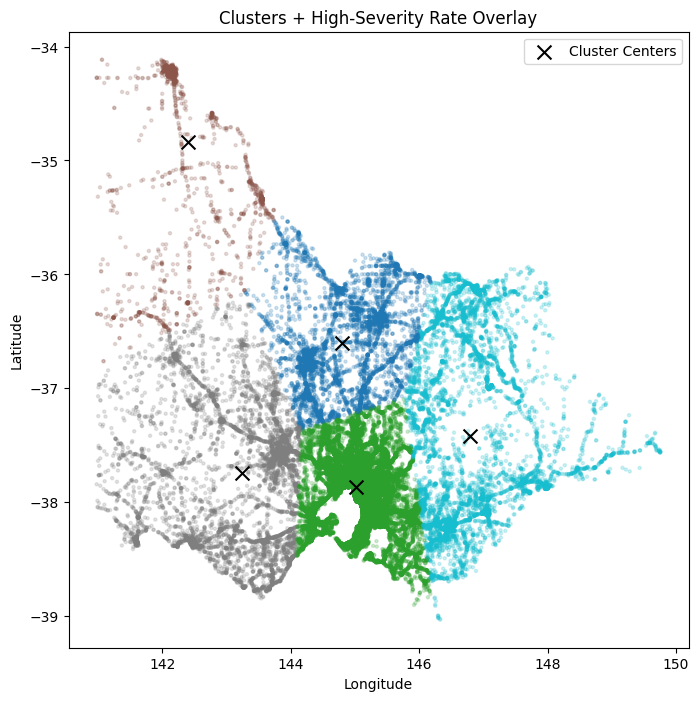

In [33]:
plt.figure(figsize=(8, 8))

# lightly plot all points
plt.scatter(
    df_loc["LONGITUDE"],
    df_loc["LATITUDE"],
    c=df_loc["CLUSTER_ID"],
    cmap="tab10",
    alpha=0.2,
    s=5,
)

# plot the cluster centers
plt.scatter(
    centers[:, 1],  # longitude
    centers[:, 0],  # latitude
    c="black",
    s=100,
    marker="x",
    label="Cluster Centers",
)

plt.legend()
plt.title("Clusters + High-Severity Rate Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.savefig(f"{os.getenv('CLUSTER_DIR')}/clusters.png")
plt.show()

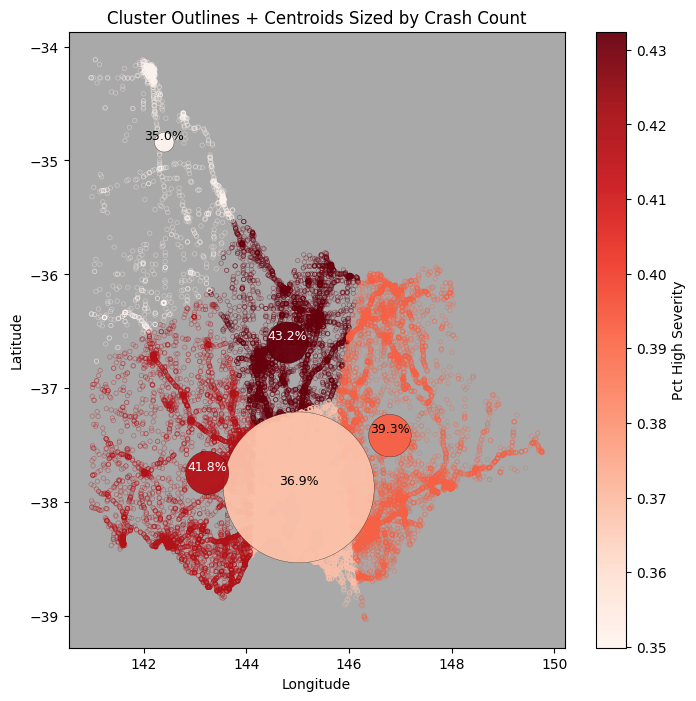

In [34]:
cluster_stats = (
    df_loc.groupby("CLUSTER_ID")
    .agg(
        count_crashes=("ACCIDENT_NO", "count"),
        pct_high_sev=("HIGH_SEVERITY", "mean"),
        lat_center=("LATITUDE", "mean"),
        lon_center=("LONGITUDE", "mean"),
    )
    .reset_index()
)


# Prepare a color map keyed to severity
norm = mcolors.Normalize(
    vmin=cluster_stats["pct_high_sev"].min(),
    vmax=cluster_stats["pct_high_sev"].max(),
)
cmap = plt.cm.Reds

plt.figure(figsize=(8, 8))  
ax = plt.gca()
ax.set_facecolor("#a9a9a9") # Set background so that can see white points

# Draw a light outline of each cluster’s scatter
for _, row in cluster_stats.iterrows():
    i = row["CLUSTER_ID"]
    pts = df_loc[df_loc["CLUSTER_ID"] == i]
    color = cmap(norm(row["pct_high_sev"]))
    plt.scatter(
        pts["LONGITUDE"],
        pts["LATITUDE"],
        facecolors="none",  # no fill
        edgecolors=color,  # match cluster severity color
        alpha=0.4,
        s=10,
        linewidth=0.5,
    )

# Overlay the centroid‐circles sized & colored
scatter = plt.scatter(
    cluster_stats["lon_center"],
    cluster_stats["lat_center"],
    s=cluster_stats["count_crashes"] / 10,
    c=cluster_stats["pct_high_sev"],
    cmap=cmap,
    norm=norm,
    edgecolors="black",
    linewidth=0.2,  
    alpha=0.95,
)

# Add the % labels
for _, row in cluster_stats.iterrows():
    text_color = "white" if row["pct_high_sev"] > 0.40 else "black"
    plt.text(
        row["lon_center"],
        row["lat_center"] + 0.00,
        f"{row['pct_high_sev']:.1%}",
        ha="center",
        va="bottom",
        fontsize=9,
        color=text_color,
    )

plt.colorbar(scatter, label="Pct High Severity")
plt.title("Cluster Outlines + Centroids Sized by Crash Count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.savefig(f"{os.getenv('CLUSTER_DIR')}/clustering_severity.png")
plt.show()

# Add New Cluster Number Feature to Both The Test and Train Datasets

In [35]:
# load integrated dataset
integrated_dataset = pd.read_csv(
    f"{os.getenv('PROCESSED_DATA_DIR')}/integrated_data.csv"
)

# Load Node dataset
node = pd.read_csv(f"{os.getenv('RAW_DATA_DIR')}/node.csv")[
    ["ACCIDENT_NO", "LATITUDE", "LONGITUDE", "NODE_TYPE"]
]

# Restrict to only those accidents present in integrated_dataset
df_loc = integrated_dataset.merge(node, on="ACCIDENT_NO", how="inner")

# Run KMeans on the raw coordinates
coords = df_loc[["LATITUDE", "LONGITUDE"]].values
km5 = KMeans(n_clusters=5, random_state=42, n_init=10)
df_loc["CLUSTER_ID"] = km5.fit_predict(coords)

# Merge new feature back into the full dataset
integrated_dataset = integrated_dataset.merge(
    df_loc[["ACCIDENT_NO", "CLUSTER_ID"]],
    on="ACCIDENT_NO",
    how="left",
)

# Save
integrated_dataset.to_csv(
    f"{os.getenv('PROCESSED_DATA_DIR')}/integrated_data.csv", index=False
)

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the integrated dataset now with new cluster feature
df = pd.read_csv(f"{os.getenv('PROCESSED_DATA_DIR')}/integrated_data.csv")

# Split into train - test
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["HIGH_SEVERITY"]
)

# Save
train_df.to_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv", index=False)
test_df.to_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/test.csv", index=False)